# Annealing and Simulation with `qubovert`

If `qubovert` is not `pip` installed and you are using these notebooks from within the `notebook_examples` directory, then run this cell. Otherwise it is not needed.

In [1]:
import sys
sys.path.append("..")

Import `qubovert`.

In [2]:
import qubovert as qv

In this notebook, we will review some basics of the annealing and simulation functionality provided by `qubovert`. Let's look at everything in the simulation (`sim`) library.

In [3]:
print(qv.sim.__all__)

('SpinSimulation', 'BooleanSimulation', 'AnnealResult', 'AnnealResults', 'anneal_qubo', 'anneal_quso', 'anneal_pubo', 'anneal_puso', 'anneal_temperature_range')


In this notebook we will discuss `SpinSimulation`, `anneal_puso`, `anneal_temperature_range`, `AnnealResults`, and `AnnealResult`. We will not discuss `BooleanSimulation`, though it is used in exactly the same way as `SpinSimulation` but with boolean function. Similarly, `anneal_qubo`, `anneal_quso`, and `anneal_puso` are all used very similarly to `anneal_puso`.

`SpinSimulation` will be discussed in the <a href="#Simulation">Simulation</a> section; `AnnealResults`, `AnnealResult`, and `anneal_puso` will be discussed in the <a href="#Annealing">Annealing</a> section; a more detailed usage of `anneal_pubo` and `anneal_temperature_range` will be discussed in the <a href="#Advanced-Annealing">Advanced Annealing</a> section.

### Table of Contents

1. <a href="#Working-Example">Working Example</a>
2. <a href="#Simulation">Simulation</a>
3. <a href="#Annealing">Annealing</a>
4. <a href="#Advanced-Annealing">Advanced Annealing</a>
  1. <a href="#Adjusting-the-temperature-range">Adjusting the temperature range</a>
  2. <a href="#Adjusting-the-initial_state">Adjusting the initial state</a>
  3. <a href="#Adjusting-the-schedule">Adjusting the schedule</a>
4. <a href="#Conclusion">Conclusion</a>
  1. <a href="#A-note-on-the-purpose-of-the-qubovert.sim-library">A note on the purpose of the `qubovert.sim` library</a>

## Working Example

For all of the following examples, we will use the following example; an Ising model on a line of length $L$ with nearest- and next-to-nearest-neighbor interactions with periodic boundary conditions. Our system is represented by the Hamiltonian

$$H = -\sum_{i=0}^{L-1} z_i z_{i+1} z_{i+2}$$

where each $z_i \in \{1, -1 \}$ and they are defined modulo $L$ such that $z_{i+L} = z_{i}$. First, let's define the length of our system and create the Hamiltonian.

In [4]:
L = 100

# define the function z that returns the ith variable modulo L
z_variables = [qv.spin_var(i) for i in range(L)]
z = lambda i: z_variables[i % L]

# create the Hamiltonian
H = 0
for i in range(L):
    H -= z(i) * z(i+1) * z(i+2)

Note that the groundstate of this Hamiltonian is the state where each $z_i = 1$ (if we did not assume periodic boundary conditions, then the ground state is degenerate, with some being more complicated then the all 1 state). 

## Simulation

We'll first create a `SpinSimulation` object for the Hamiltonian. We will add some memory to the object. The `memory` keyword indicates how many of the most recent states to remember. We will use this later.

In [5]:
sim = qv.sim.SpinSimulation(H, memory=1000)

Let's put the simulation in a random state. Ie each of the $L$ spins is randomly oriented in the 1 or -1 direction.

In [6]:
import random

initial_state = {i: random.choice((-1, 1)) for i in range(L)}
sim.set_state(initial_state)

print(sim.state)

{0: -1, 1: 1, 2: 1, 3: -1, 4: -1, 5: -1, 6: 1, 7: 1, 8: -1, 9: -1, 10: 1, 11: -1, 12: -1, 13: -1, 14: -1, 15: 1, 16: -1, 17: -1, 18: -1, 19: 1, 20: 1, 21: -1, 22: -1, 23: -1, 24: 1, 25: 1, 26: 1, 27: 1, 28: -1, 29: 1, 30: 1, 31: -1, 32: -1, 33: -1, 34: 1, 35: -1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: -1, 42: -1, 43: -1, 44: -1, 45: 1, 46: 1, 47: 1, 48: 1, 49: -1, 50: 1, 51: 1, 52: -1, 53: 1, 54: -1, 55: 1, 56: 1, 57: -1, 58: 1, 59: -1, 60: 1, 61: 1, 62: -1, 63: 1, 64: -1, 65: 1, 66: 1, 67: 1, 68: -1, 69: -1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: -1, 76: 1, 77: -1, 78: 1, 79: 1, 80: -1, 81: 1, 82: -1, 83: -1, 84: 1, 85: 1, 86: -1, 87: -1, 88: -1, 89: 1, 90: 1, 91: -1, 92: -1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: -1, 99: -1}


Next we'll define a schedule to simulate the system. A schedule is a collection of `(T, n)` pairs, where `T` is the temperature to update the simulation at, and `n` is the number of time steps to simlulate the system at that temperature. Let's cool the system from temperature 5 to 0.5.

In [7]:
schedule = (5, 20), (4, 25), (3, 30), (2, 35), (1, 40), (.5, 100)

Next we simulate the system with this schedule.

In [8]:
sim.schedule_update(schedule)

We can look at exactly what state the simulation was in at each time step by looking into the memory.

In [9]:
all_states = sim.get_past_states()

Notice that the 0th state should be the same as the initial state, and the last state should be the same as the current state. *Note that if you did not provide the `SpinSimulation` object with enough memory then it will have forgotten about the initial_state!*

In [10]:
print(all_states[0] == initial_state)
print(all_states[-1] == sim.state)

True
True


Now, let's do the same thing, but 100 times! We'll keep track of the state that the simulation ends in at each iteration.

In [11]:
ending_states = []
for _ in range(100):
    sim.reset()
    sim.set_state([random.choice((-1, 1)) for _ in range(L)])
    sim.schedule_update(schedule)
    ending_states.append(sim.state)

Finally, let's calculate the average correlation that each spin has to the 0th spin over the ending states.

In [12]:
# avg_correaltion[i] is the average correlation of spin i to spin 0
avg_correlation = [
    sum(s[0] * s[i] for s in ending_states) / len(ending_states)
    for i in range(L)
]

Finally we plot it! *You must have `matplotlib` pip installed.*

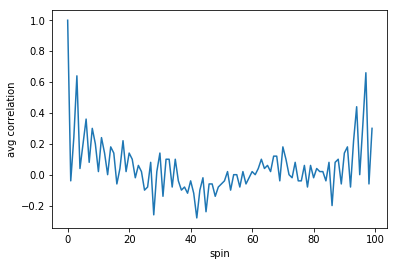

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(avg_correlation)
plt.xlabel('spin')
plt.ylabel('avg correlation')
plt.show()

As a sanity check, we see that the correlation between spin 0 and itself is always 1! Similarly, we see the correlation begin to go up towards the end of the chain; this is because of the periodic boundary conditions.

<a href="#Table-of-Contents">Back to Table of Contents</a>

## Annealing

Here we show basic usage of the `anneal_puso` function. We will use it to try to find the groundstate of the Hamiltonian discuessed and created in the <a href="#Working-Example">Working Example</a> section. Let's anneal the Hamiltonian to see if we can find the groundstate. Recall that PUSO is short for Polynomial Unconstrained Spin Optimization. We can use the `anneal_puso` function to anneal the Hamiltonian.

For the sake of reproducability, we will seed the random number generator that `anneal_puso` uses.

In [14]:
res = qv.sim.anneal_puso(H, num_anneals=10, seed=34)

Let's look at the result that if found with the lowest energy.

In [15]:
print(res.best)

  state: {0: -1, 1: 1, 2: -1, 3: -1, 4: 1, 5: -1, 6: -1, 7: 1, 8: -1, 9: -1, 10: 1, 11: -1, 12: -1, 13: -1, 14: 1, 15: -1, 16: -1, 17: 1, 18: -1, 19: -1, 20: 1, 21: -1, 22: -1, 23: 1, 24: -1, 25: -1, 26: 1, 27: -1, 28: -1, 29: 1, 30: -1, 31: -1, 32: 1, 33: -1, 34: -1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: -1, 58: -1, 59: 1, 60: -1, 61: -1, 62: 1, 63: -1, 64: -1, 65: 1, 66: -1, 67: -1, 68: 1, 69: -1, 70: -1, 71: 1, 72: -1, 73: -1, 74: 1, 75: -1, 76: -1, 77: 1, 78: -1, 79: -1, 80: 1, 81: -1, 82: -1, 83: 1, 84: -1, 85: -1, 86: 1, 87: -1, 88: -1, 89: 1, 90: -1, 91: -1, 92: 1, 93: -1, 94: -1, 95: 1, 96: -1, 97: -1, 98: 1, 99: -1}
  value: -94
   spin: True


Notice that none of the 10 results found the ground state! But if we increase the duration of each anneal, then we can. By default, the anneal duration (the number of time steps to run each simulation for) is 1000. Let's increase it to 7500 and see if it finds the ground state.

In [16]:
res = qv.sim.anneal_puso(H, num_anneals=10, anneal_duration=7500, seed=34)
print(res.best)

  state: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
  value: -100
   spin: True


Indeed we find the ground state! Adjusting the anneal duration is one thing you can do to try to get better performance out of the annealer. In the next section, we will discuss some more.

Now let's look at the result. `res` is a `qubovert.sim.AnnealResults` object. It will contain 10 results, since we set `num_anneals` to 10.

In [17]:
len(res)

10

Let's look at the result that it found with the lowest energy. `res.best` is a `qubovert.sim.AnnealResult` object. We can get the state with `.state` and the energy with `.value`.

In [18]:
print("Energy", res.best.value)
print("State", res.best.state)

Energy -100
State {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}


Let's sort the results and then look at all 10 of them.

In [19]:
res.sort_by_value()
print(res)

AnnealResults
  state: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
  value: -100
   spin: True

  state: {0: -1, 1: -1, 2: 1, 3: -1, 4: -1, 5: 1, 6: -1, 7: -1, 8: 1, 9: -1, 10: -1, 11: 1, 12: -1, 13: -1, 14: 1, 15: -1, 16: -1, 17: 1, 18: -1, 19: -1, 20: 1, 21: -1, 22: -1, 23: 1, 24: -1, 25: -1, 26: 1, 27: -1, 28: -1, 29: 1, 30: -1, 31: -1, 32: 1, 33: 

We can access each individual result by iterating through `res`. Each element in `res` is also a `qubovert.sim.AnnealResult` object. For each result, let's count the number of 1s and -1s.

In [20]:
for s in res:
    print("Energy:", s.value)
    print("  Number of 1s:", sum(v for v in s.state.values() if v == 1))
    print("  Number of -1s:", sum(-v for v in s.state.values() if v == -1))

Energy: -100
  Number of 1s: 100
  Number of -1s: 0
Energy: -98
  Number of 1s: 33
  Number of -1s: 67
Energy: -96
  Number of 1s: 44
  Number of -1s: 56
Energy: -94
  Number of 1s: 33
  Number of -1s: 67
Energy: -94
  Number of 1s: 47
  Number of -1s: 53
Energy: -94
  Number of 1s: 53
  Number of -1s: 47
Energy: -92
  Number of 1s: 88
  Number of -1s: 12
Energy: -90
  Number of 1s: 41
  Number of -1s: 59
Energy: -90
  Number of 1s: 47
  Number of -1s: 53
Energy: -88
  Number of 1s: 34
  Number of -1s: 66


In the next section we will review some of the more advanced annealing features that can be used.

<a href="#Table-of-Contents">Back to Table of Contents</a>

## Advanced Annealing

To see what advanced options we can play with when annealing, let's look at the docstring of the `anneal_puso` function.

In [21]:
help(qv.sim.anneal_puso)

Help on function anneal_puso in module qubovert.sim._anneal:

anneal_puso(H, num_anneals=1, anneal_duration=1000, initial_state=None, temperature_range=None, schedule='geometric', seed=None)
    anneal_puso.
    
    Run a simulated annealing algorithm to try to find the minimum of the PUSO
    given by ``H``. ``anneal_puso`` uses a cooling schedule with the
    ``qubovert.sim.SpinSimulation`` object. Please see all of the parameters
    for details.
    
    Parameters
    ----------
    H : dict, or any type in ``qubovert.SPIN_MODELS``.
        Maps spin labels to their values in the Hamiltonian.
        Please see the docstrings of any of the objects in
        ``qubovert.SPIN_MODELS`` to see how ``H`` should be formatted.
    num_anneals : int >= 1 (optional, defaults to 1).
        The number of times to run the simulated annealing algorithm.
    anneal_duration : int >= 1 (optional, defaults to 1000).
        The total number of updates to the simulation during the anneal.
      

Notice the `anneal_duration` argument that we played with in the previous section. Next we will show examples using `initial_state`, `temperature_range`, and `schedule``.

### Adjusting the temperature range

We can adjust the `temperature_range` argument in `anneal_puso`. This argument is a tuple of values `(T0, Tf)` that indicate the temperature to start and end the anneal. To get an idea of what temperatures to pick. We will look at the `anneal_temperature_range` function.

The `anneal_temperature_range` function accepts a model and a start and end flip probability. These indicate how probable we want it to be that a bit is flipped even if it results in a worse energy. By default these values are set at 50% at the beginning of the anneal, and 1% at the end of the anneal. In other words, at the beginning of the anneal, the temperature is set such that every spin has at least a 50% chance of being flipped even if it results in a worse energy. Similarly, at the end of the anneal, the temperature is set such that every spin has at most a 1% chance of being flipped if when flipping it results in a worse energy. Let's look at what the temperature range would be for our Hamiltonian.

In [22]:
# spin indicates that this is a spin model
T0, Tf = qv.sim.anneal_temperature_range(H, spin=True)
print(T0, Tf)

8.656170245333781 0.43429448190325187


We can play around with the start and end flip probabilities to see how they affect the temperature.

In [23]:
# spin indicates that this is a spin model
T0, Tf = qv.sim.anneal_temperature_range(H, start_flip_prob=.75, end_flip_prob=.001, spin=True)
print(T0, Tf)

20.856356980693242 0.2895296546021679


You can adjust the temperature range in `anneal_puso` via `anneal_puso(H, temperature_range=(T0, Tf), ...)`.

### Adjusting the initial state

If we do not provide an initial state to the anneal function, then it will randomly initialize a new state at the start of each anneal. However, if we provide an initial state, then it will begin in this state at the beginning of each anneal. This could be useful if we already have a decent idea of what our solution might look like. 

Let's take the example of the Hamiltonian $H$ from above. What if we start out in a state where the first 75 spins are 1 and the last 25 spins are -1? If we use the intuition that we are sort of close to the true ground state, then we should probably reduce the starting flip probability. So we will make the starting flip probability equal to 25% and keep the ending flip probability at 1%. This is how we will set the temperature. *Note that since we know that 75% of the spins are oriented correctly, 25% spin flip probability is a reasonable guess. Of course for a problem where the ground state is a mystery, we would not know this.*

In [24]:
initial_state = {i: 1 if i < 75 else -1 for i in range(L)}

temperature_range = qv.sim.anneal_temperature_range(
    H, start_flip_prob=.25, end_flip_prob=0.01, spin=True,
)

res = qv.sim.anneal_puso(
    H, 
    initial_state=initial_state, 
    temperature_range=temperature_range,
    num_anneals=10,
    anneal_duration=2500,
    seed=34
)

print(res.best)

  state: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
  value: -100
   spin: True


Notice that we get the right answer with `anneal_duration=2500`, whereas in the previous section we needed around 7500!

### Adjusting the schedule

The last topic we will discuss is adjusting the schedule. There are three options for the `schedule` argument.

1. Geometric (`schedule='geometric'`). This is the default option in `anneal_puso` (learned from D-Wave's simulated annealing software). In this case, the temperature will be decreased from from the initial to final temperature in evenly spaced increments along a log scale.
2. Linear (`schedule='linear'`). In this case, the temperature will be decreased from from the initial to final temperature in evenly spaced increments along a linear scale.
3. Custom. 

For the custom schedule, we can provide a schedule exactly as we did in the <a href="#Simulation">Simulation</a> example in the first section. A schedule is a collection of `(T, n)` pairs, where `T` is the temperature to update the simulation at, and `n` is the number of time steps to simlulate the system at that temperature.

We will show a custom schedule example. Consider exactly the above example in the <a href="#Adjusting-the-initial-state">Adjusting the initial state</a> section, where we start off in an initial state that we think is pretty close to the optimal state. We will start off in a state where the first 75 spins are 1 and the last 25 are -1. For the same reasons as above, we will make the temperature range such that we start the anneal with a 25% chance of flipping a spin even if it is energetically unfavorable, and we will end with 1% chance. But this time we will customize the schedulee so that it first *reverse anneals*, and then anneals. See <a href="https://docs.dwavesys.com/docs/latest/c_fd_ra.html">D-Wave reverse annealing</a> for some info on reverse quantum annealing.

We will use the same $T_0, T_f$ as before, but this time we will create a geometric schedule where we *start* with temperature $T_f$ and heat the system to $T_0$ quickly (50 time steps). Then we will cool the system with a geometric schedule from $T_0$ to $T_f$ in 1950 time steps.

In [25]:
from numpy import geomspace

T0, Tf = temperature_range  # same as the previous cell

schedule = [
    (T, 1) for T in geomspace(Tf, T0, 50)
] + [
    (T, 1) for T in geomspace(T0, Tf, 1950)
]
    

res = qv.sim.anneal_puso(
    H, 
    initial_state=initial_state,
    num_anneals=10,
    schedule=schedule,
    seed=34
)

print(res.best)

  state: {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1, 20: 1, 21: 1, 22: 1, 23: 1, 24: 1, 25: 1, 26: 1, 27: 1, 28: 1, 29: 1, 30: 1, 31: 1, 32: 1, 33: 1, 34: 1, 35: 1, 36: 1, 37: 1, 38: 1, 39: 1, 40: 1, 41: 1, 42: 1, 43: 1, 44: 1, 45: 1, 46: 1, 47: 1, 48: 1, 49: 1, 50: 1, 51: 1, 52: 1, 53: 1, 54: 1, 55: 1, 56: 1, 57: 1, 58: 1, 59: 1, 60: 1, 61: 1, 62: 1, 63: 1, 64: 1, 65: 1, 66: 1, 67: 1, 68: 1, 69: 1, 70: 1, 71: 1, 72: 1, 73: 1, 74: 1, 75: 1, 76: 1, 77: 1, 78: 1, 79: 1, 80: 1, 81: 1, 82: 1, 83: 1, 84: 1, 85: 1, 86: 1, 87: 1, 88: 1, 89: 1, 90: 1, 91: 1, 92: 1, 93: 1, 94: 1, 95: 1, 96: 1, 97: 1, 98: 1, 99: 1}
  value: -100
   spin: True


Notice this time we get the right answer with a total anneal duration of 2000, whereas before we needed around 2500!

<a href="#Table-of-Contents">Back to Table of Contents</a>

## Conclusion

### A note on the purpose of the `qubovert.sim` library

I'd like to remark that D-Wave's QUBO and QUSO simulated annealing implementations in their Python package `neal` is *dramatically* faster than `qubovert`'s implementations. If your goal is to use simulated annealing to find the ground state of a QUBO or QUSO, then you should probably use `neal`. In fact, the main purpose of `qubovert` is to aid in the formulation of binary optimization models so that they can easily be sent to D-Wave (either their simulated or quantum annealer). See all the other notebooks where I use `neal` to solve the models that I create.

However, `neal` does not provide the functionality for simulated annealing of PUBOs and PUSOs, nor does it allow the ability to provide an arbitrary temperature schedule. If your goal is to research different schedules (like we did with the reverse annealing example) or to solve higher order models that are expensive to reduce to QUBOs and QUSOs, then the `qubovert.sim` library may be useful. Similarly, if you are interested in how physical systems behave with time and temperature, then `qubovert`'s simulation functionaliy may be useful; for example, see a <a href="https://github.com/jiosue/ising_sim">graphical simulation implementation</a> that I wrote for the 1D ferromagnetic Ising chain.

<a href="#Table-of-Contents">Back to Table of Contents</a>